In [1]:
import os
import glob
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

In [2]:
conf_list = ["AAAI", "CVPR", "ICML", "KDD", "NeurIPS1"]
conf_map = {name: i for i, name in enumerate(conf_list)}
root_dir = "spider"
batch_size = 8
num_epochs = 20

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备:", device)

使用设备: cuda


In [4]:
entity_df = pd.read_csv("entity_embeddings.csv", index_col=0)
entity_emb_dict = entity_df.to_dict(orient="index")
kg_dim = len(next(iter(entity_emb_dict.values())))

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

In [6]:
for param in bert_model.parameters():
    param.requires_grad = False

In [7]:
# 解冻最后两层（encoder.layer.10, encoder.layer.11）和 pooler
for name, param in bert_model.named_parameters():
    if any(n in name for n in ["encoder.layer.10", "encoder.layer.11", "pooler"]):
        param.requires_grad = True

In [8]:
class PaperDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.labels = []
        for conf in conf_list:
            txt_dir = os.path.join(root_dir, conf, "txt")
            for path in glob.glob(os.path.join(txt_dir, "*.txt")):
                with open(path, "r", encoding="utf-8", errors="ignore") as f:
                    text = f.read()
                paper_id = os.path.basename(path).replace(".txt", "")
                label = conf_map[conf]
                self.samples.append((paper_id, text))
                self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        paper_id, text = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        tokens = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256).to(device)
        text_emb = bert_model(**tokens).pooler_output.squeeze(0)

        if paper_id in entity_emb_dict:
            kg_vector = list(entity_emb_dict[paper_id].values())
            kg_emb = torch.tensor(kg_vector, dtype=torch.float)
        else:
            kg_emb = torch.zeros(kg_dim, dtype=torch.float)

        kg_emb = kg_emb.to(device)
        return torch.cat([text_emb, kg_emb]), label.to(device)

In [9]:
class PaperClassifier(nn.Module):
    def __init__(self, kg_dim, num_classes):
        # super().__init__()
        # self.net = nn.Sequential(
        #     nn.Linear(768 + kg_dim, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, num_classes)
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(768 + kg_dim, 512),
            nn.LayerNorm(512),  # 添加归一化层
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
dataset = PaperDataset(root_dir)
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# ====== 初始化模型 ======
model = PaperClassifier(kg_dim=kg_dim, num_classes=len(conf_list)).to(device)
criterion = nn.CrossEntropyLoss()
bert_params = list(filter(lambda p: p.requires_grad, bert_model.parameters()))
optimizer = torch.optim.Adam(
    list(model.parameters()) + bert_params,
    lr=1e-5  # 微调 BERT 建议更小的学习率
)

In [11]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (logits.argmax(1) == y).sum().item()
    train_losses.append(total_loss)
    train_accs.append(correct / len(train_dataset))

    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            val_loss += criterion(logits, y).item()
            val_correct += (logits.argmax(1) == y).sum().item()
    val_losses.append(val_loss)
    val_accs.append(val_correct / len(val_dataset))

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_accs[-1]:.4f}")


Epoch 1/20 | Train Loss: 76.2041 | Val Loss: 14.8010 | Train Acc: 0.4370 | Val Acc: 0.5763
Epoch 2/20 | Train Loss: 50.3300 | Val Loss: 10.7127 | Train Acc: 0.6681 | Val Acc: 0.7034
Epoch 3/20 | Train Loss: 37.4801 | Val Loss: 9.7784 | Train Acc: 0.7773 | Val Acc: 0.7203
Epoch 4/20 | Train Loss: 31.0280 | Val Loss: 8.1841 | Train Acc: 0.8256 | Val Acc: 0.7966
Epoch 5/20 | Train Loss: 24.9618 | Val Loss: 7.8620 | Train Acc: 0.8866 | Val Acc: 0.8136
Epoch 6/20 | Train Loss: 21.5500 | Val Loss: 8.8636 | Train Acc: 0.8929 | Val Acc: 0.7542
Epoch 7/20 | Train Loss: 17.6750 | Val Loss: 7.2651 | Train Acc: 0.9286 | Val Acc: 0.8390
Epoch 8/20 | Train Loss: 13.6104 | Val Loss: 6.6687 | Train Acc: 0.9391 | Val Acc: 0.8644
Epoch 9/20 | Train Loss: 10.9799 | Val Loss: 5.8267 | Train Acc: 0.9664 | Val Acc: 0.8559
Epoch 10/20 | Train Loss: 8.2153 | Val Loss: 6.7546 | Train Acc: 0.9832 | Val Acc: 0.8729
Epoch 11/20 | Train Loss: 7.4589 | Val Loss: 9.3608 | Train Acc: 0.9874 | Val Acc: 0.8305
Epoch 12

In [13]:
from sklearn.preprocessing import label_binarize

full_loader = DataLoader(dataset, batch_size=batch_size)

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in full_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

preds = np.argmax(all_probs, axis=1)
accuracy = accuracy_score(all_labels, preds)
precision = precision_score(all_labels, preds, average='macro')
recall = recall_score(all_labels, preds, average='macro')
f1 = f1_score(all_labels, preds, average='macro')

# all_labels_bin = label_binarize(all_labels, classes=list(range(len(conf_list))))
# auc = roc_auc_score(all_labels_bin, np.array(all_probs), average="macro", multi_class='ovr')

print("\n=== Final Evaluation Metrics ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


=== Final Evaluation Metrics ===
Accuracy:  0.9747
Precision: 0.9811
Recall:    0.9658
F1 Score:  0.9730


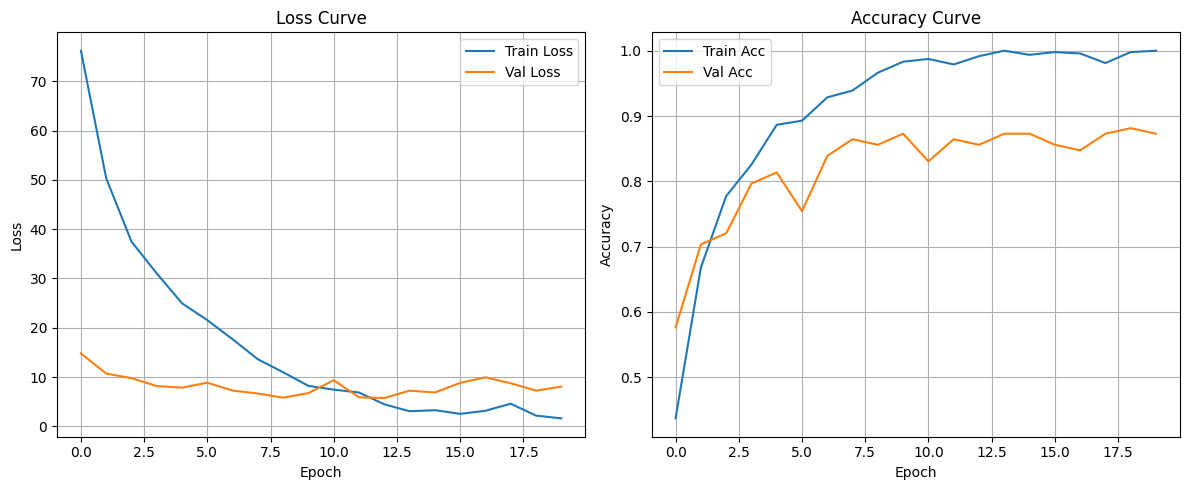

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()